In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import osmnx as ox
import math
import pandas as pd
import random
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import norm
 
from funciones import read_data, calcular_distancia, calcular_matriz_dist, calcular_largo_ruta, graficar_ruta
from solvers_listos import generar_ruta, graficar_rutas 
# from instancia import ubis, cap_tpte, info_locales
# from instancia import G, color_nodos, color_arcos, ancho_edges
from instancia import crear_grafo_inicial
from ruteo_alns import ruteo_ALNS

random.seed(1)
np.random.seed(1)

{0: 0, 1: 91, 2: 27, 3: 11, 4: 63, 5: 69, 6: 67, 7: 91, 8: 46, 9: 73, 10: 66}


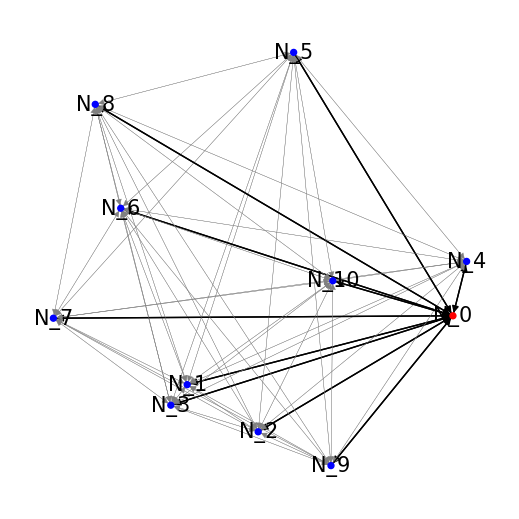

{'Inv': 1428, 'Up': 100000, 'Low': 0, 'Prod': -581, 'h': 0.3, 'coord_x': 444, 'coord_y': 237, 'pos': (444, 237)}
{'Inv': 99, 'Up': 174, 'Low': 0, 'Prod': 75, 'h': 0.23, 'coord_x': 152, 'coord_y': 180, 'pos': (152, 180)}
{'Inv': 26, 'Up': 54, 'Low': 0, 'Prod': 28, 'h': 0.32, 'coord_x': 230, 'coord_y': 141, 'pos': (230, 141)}
{'Inv': 8, 'Up': 30, 'Low': 0, 'Prod': 22, 'h': 0.33, 'coord_x': 134, 'coord_y': 163, 'pos': (134, 163)}
{'Inv': 33, 'Up': 110, 'Low': 0, 'Prod': 77, 'h': 0.23, 'coord_x': 459, 'coord_y': 282, 'pos': (459, 282)}
{'Inv': 148, 'Up': 213, 'Low': 0, 'Prod': 65, 'h': 0.18, 'coord_x': 269, 'coord_y': 455, 'pos': (269, 455)}
{'Inv': 101, 'Up': 138, 'Low': 0, 'Prod': 37, 'h': 0.29, 'coord_x': 79, 'coord_y': 326, 'pos': (79, 326)}
{'Inv': 123, 'Up': 237, 'Low': 0, 'Prod': 114, 'h': 0.42, 'coord_x': 5, 'coord_y': 235, 'pos': (5, 235)}
{'Inv': 40, 'Up': 129, 'Low': 0, 'Prod': 89, 'h': 0.42, 'coord_x': 51, 'coord_y': 412, 'pos': (51, 412)}
{'Inv': 87, 'Up': 154, 'Low': 0, 'Prod

In [2]:
G, ubis, cap_tpte, info_locales = crear_grafo_inicial(archivo= 'IRP1.xlsx' ,plot=True)
for nodo in G.nodes(data=True):
    si_o_no = random.randint(0,1)
    if True and nodo[0] != 'N_0':
        up = nodo[1]['Up']
        new_d = random.randint(int(up*0.25), int(up*0.75))
        G.nodes[nodo[0]]['Prod'] = new_d
        G.nodes[nodo[0]]['Inv'] = up - new_d

    print(G.nodes(data=True)[nodo[0]])

In [3]:
def reaccion_inventario(grafo, mu, sd, alfa = 0.05):
    """
    Función que verifica que locales deben ser visitados en base a su inventario actual. 
    En caso de que el inventario se encuentre bajo el umbral de tolerancia, se retorna True.
    """
    grafo = G.copy()
    visitas = {nodo : False for nodo in G.nodes()}
    for nodo in grafo.nodes(data=True):
        id_nodo = int(nodo[0][2:])-1
        media = mu[id_nodo]
        desviacion = sd[id_nodo]
        s = media + norm.ppf((1 - alfa)/2)* desviacion  #Stock de segrafouridad
        if nodo[1]['Inv'] <= s:
            visitas[nodo[0]] = True
    
    return visitas

In [4]:
def IC_nrm(mu, sd, M=1000, alfa = 0.95):
    """
    Función que calcula el intervalo de confianza para una distribución normal.
    """
    limite_inferior = mu + norm.ppf((1 - alfa) / 2) * sd / math.sqrt(M)
    limite_superior = mu - norm.ppf((1 - alfa) / 2) * sd / math.sqrt(M)
    
    return limite_inferior, limite_superior

In [5]:
def simular_demanda_previa(G, dist = 'n', T =100, ruido = 0):
    """
    Función que simula la demanda previa de los locales.
    """
    g = G.copy()
    demandas = {nodo : [] for nodo in g.nodes() if nodo != 'N_0'}
    # r = {nodo : nodo[1]['Prod'] for nodo in G.nodes(data=True)}
    if dist == 'n':
        for nodo in g.nodes(data=True):
            # print(nodo[0],nodo[1]['Prod'])
            if nodo[0] != 'N_0':
                dem_pasadas = [max(
                    np.random.normal(loc = nodo[1]['Prod'], scale = nodo[1]['Prod'] * 0.05) 
                    + np.random.normal(loc = 0, scale = nodo[1]['Prod'] * ruido)
                    ,0) for _ in range(T)]
                demandas[nodo[0]] = dem_pasadas
         
    return demandas

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

#ejemplo demanda historica

muestra = False

if muestra:
    dem_historico = simular_demanda_previa(G, dist = 'n', T=1000, ruido=0.05) 
    demanda = {nodo: dem_historico[nodo][-1] for nodo in dem_historico.keys()}
    print(demanda)
    print(dem_historico.keys())
    plt.figure(figsize=(10, 5))
    plt.plot(demanda.values(), 'o', color='black') 
    # for nodo in dem_historico.keys():
    #     if nodo != 'N_0':
    #         # plt.plot(dem_historico[nodo])
    #         plt.plot(smooth(dem_historico[nodo], 10))
    plt.xlabel('Días')
    plt.ylabel('Demanda')
    plt.xticks(np.arange(len(demanda)), demanda.keys())
    plt.title('Demanda histórica')
    plt.show()


In [6]:
def SEDA(datos, historia = False, alpha=0.1, beta=0.1, theta=0.5):
    '''
    Suavizamiento Exponencial Doble Amortiguado
    Aplica el método de suavizamiento exponencial doble a una serie de datos,
    específicmamente el Método de Holt Damped.
    '''
    I = [datos[0]]
    S = [datos[1]-datos[0]]
    for i in range(1,len(datos)):
        I.append(alpha*datos[i] + (1-alpha)*(I[i-1]+ theta*S[i-1]))
        S.append(beta*(I[i]-I[i-1])+(1-beta)*S[i-1])
    
    y = I[-1] + theta * S[-1]
    if historia == False:
        return y
    elif historia == True:
        I.append(y)
        return I
    elif historia == 'S':
        return I, S
    
def pronostico_SEDA(datos, T, pron = False, alpha=0.1, beta=0.1, theta=0.5):
    '''
    Devuelve un pronóstico para los siguientes T periodos mediante Suavizamiento Exponencial Doble Amortiguado
    '''
    I,S = SEDA(datos, historia = 'S', alpha=alpha, beta=beta, theta=theta)
    pronostico = []
    for i in range(T):
        y = I[-1] + theta * S[-1]
        pronostico.append(y)
        I.append(alpha*y + (1-alpha)*(I[-1]+ theta*S[-1]))
        S.append(beta*(I[-1]-I[-2]) + (1-beta)*S[-1])
    
    return pronostico

muestra = False

if muestra:
    dem_historico = simular_demanda_previa(G, dist = 'n', T=1000, ruido = 0.05) 
    demanda = {nodo: dem_historico[nodo][-1] for nodo in dem_historico.keys()}
    data = {nodo: dem_historico[nodo][1:] for nodo in dem_historico.keys()}
    y = [SEDA(data[nodo], historia=False, alpha = 0.5) for nodo in data.keys()]
    medias = [np.mean(data[nodo]) for nodo in data.keys()]
    ind = np.arange(len(y))

    # y = [SEDA(dem_historico[nodo], pron=True, alpha = 0.5) for nodo in set(dem_historico)-set(['N_0'])]
    # medias = [np.mean(dem_historico[nodo]) for nodo in set(dem_historico)-set(['N_0'])]
    # ind = np.arange(len(y))
    
    # print(y)
    ancho = 0.3
    plt.figure(figsize=(10, 5))
    plt.plot(y, 'o', label='Pronóstico', color='red')
    plt.plot(medias, 'o', label='Promedio', color='blue')
    plt.plot(demanda.values(), 'o', label='Realización', color='black')
    # plt.bar(ind, y, width=ancho, label='Pronóstico', color='red')
    # plt.bar(ind + ancho, medias, width=ancho, label='Promedio', color='blue')
    plt.xticks(ind + ancho / 2, [f'N_{i}' for i in range(1,len(y)+1)])

    plt.xlabel('Local')
    plt.ylabel('Demanda')
    plt.title('Demanda: Pronóstico y realización para t+1')
    plt.legend()
    plt.show()

In [7]:
for nodo in G.nodes(data=True):
    print(nodo[0],nodo[1]['Inv'])

N_0 1428
N_1 99
N_2 26
N_3 8
N_4 33
N_5 148
N_6 101
N_7 123
N_8 40
N_9 87
N_10 102


In [8]:
def ejecutar_ruta(G,ruta,matriz_dst):
    """
    Función que simula la ejecución de una ruta.
    """
    g = G.copy()
    ruta = ruta.copy()
    ruta.pop(0)
    ruta.pop(-1)
    ruta = [int(nodo[2:]) for nodo in ruta]
    # distancia = calcular_largo_ruta(ruta, matriz_dst)
    stock = 0
    for nodo in ruta:
        stock += g.nodes[f'N_{nodo}']['Up'] - G.nodes[f'N_{nodo}']['Inv']
        g.nodes[f'N_{nodo}']['Inv'] = G.nodes[f'N_{nodo}']['Up']
    g.nodes['N_0']['Inv'] -= stock
    return g, stock

def realizacion_demanda(G, ruido = 0.05):
    """
    Función que simula la demanda de los locales para un determinado periodo.
    """
    grafo = G.copy()
    demandas = {nodo : [] for nodo in G.nodes() if nodo != 'N_0'}
    insatisfecho = 0
    for nodo in grafo.nodes(data=True):
        if nodo[0] != 'N_0':
            dem = max(
                np.random.normal(loc = nodo[1]['Prod'], scale = nodo[1]['Prod'] * 0.05) 
                + np.random.normal(loc = 0, scale = nodo[1]['Prod'] * 0.05)
                ,0)
            demandas[nodo[0]] = dem
            if dem <= grafo.nodes[nodo[0]]['Inv']:
                grafo.nodes[nodo[0]]['Inv'] -= dem
            else:
                grafo.nodes[nodo[0]]['Inv'] = 0
                insatisfecho += dem - grafo.nodes[nodo[0]]['Inv']

    return grafo, demandas, insatisfecho
Gprima, d, ins = realizacion_demanda(G)

for nodo in Gprima.nodes(data=True):
    print(nodo[0],nodo[1]['Inv'])

N_0 1428
N_1 20.202791437450628
N_2 0.24159652418747868
N_3 0
N_4 0
N_5 82.77357665811601
N_6 65.10636062903745
N_7 13.026887884486968
N_8 0
N_9 23.51846019533056
N_10 12.281124022123336


In [9]:
dem_historico_test = simular_demanda_previa(G, dist = 'n', T=1000) 
mu_d = [np.mean(dem_historico_test[nodo]) for nodo in dem_historico_test.keys()]    
sd_d = [np.std(dem_historico_test[nodo]) for nodo in dem_historico_test.keys()]
vis = reaccion_inventario(G, mu_d, sd_d)
np.sum(mu_d)

661.4165308843571

In [10]:
def simular_ejecucion_R(grafo_inicial = G, T=1):
    # Inicializar variables     
    # ---------------------
    G0 = grafo_inicial.copy()
    matriz_dst = calcular_matriz_dist(G0)
    ubicaciones = list(G0.nodes()) # Lista de ubicaciones
    inventarios = [G0.nodes(data=True)[i]['Inv'] for i in ubicaciones] # Lista de inventarios
    h = [G0.nodes(data=True)[i]['h'] for i in ubicaciones] # Lista de costos de inventario
    rutas = {t : [] for t in range(T)} # Lista de rutas
    dem_historico = simular_demanda_previa(G0, dist = 'n', T=1000) 
    perdido = 0
    print("Inventario inicial: ")
    for nodo in G0.nodes(data=True):
            print(nodo[0],nodo[1]['Inv'])
    print("\n")

    for t in range(T):
        mu_demanda = [np.mean(dem_historico[nodo]) for nodo in dem_historico.keys()]    
        sd_demanda = [np.std(dem_historico[nodo]) for nodo in dem_historico.keys()]
        # pronostico = [pronostico_SEDA(dem_historico[nodo], T = 10, pron = True, alpha=0.1, beta=0.1, theta=0.5) for nodo in dem_historico.keys()]

        # Estrategia Reactiva (R)  
        visitas_reaccion = reaccion_inventario(G0, mu_demanda, sd_demanda)
        # print("Visitas reacción: ", visitas_reaccion)
        
        if sum(visitas_reaccion.values()) == 0:
            print("No hay locales que visitar")
            rutas[t] = []

        else:    
            ruta_R, largo_ruta_R = generar_ruta(G0, matriz_dst, visitas_reaccion) #devuelve la ruta a realizar
            rutas[t] = ruta_R
            print(f"Ruta {t}: ", ruta_R )
            G0, stock = ejecutar_ruta(G0, ruta_R, matriz_dst)
            
        G0, demanda, insatisfecho = realizacion_demanda(G0)
        perdido += insatisfecho

        inventarios = [G0.nodes(data=True)[i]['Inv'] for i in ubicaciones]

        costo = sum([h[i]*inventarios[i] for i in range(len(inventarios))])
        
        for nodo in ubicaciones:
            if nodo != 'N_0':
                dem_historico[nodo].append(demanda[nodo])
    print('\n')
    print("Inventario final: ")
    for nodo in G0.nodes(data=True):
        print(nodo[0],nodo[1]['Inv'])
    print(f'Demanda perdida total: {perdido} | Demanda perdida promedio: {perdido/T}')
    
    return rutas, dem_historico
        
        
mis_rutas, dem_historico = simular_ejecucion_R(grafo_inicial = G, T = 365)
        

Inventario inicial: 
N_0 1428
N_1 99
N_2 26
N_3 8
N_4 33
N_5 148
N_6 101
N_7 123
N_8 40
N_9 87
N_10 102


Ruta 0:  ['N_0', 'N_4', 'N_2', 'N_3', 'N_8', 'N_0']
Ruta 1:  ['N_0', 'N_4', 'N_2', 'N_3', 'N_8', 'N_0']
Ruta 2:  ['N_0', 'N_4', 'N_2', 'N_3', 'N_8', 'N_0']
Ruta 3:  ['N_0', 'N_4', 'N_2', 'N_3', 'N_8', 'N_0']
Ruta 4:  ['N_0', 'N_4', 'N_2', 'N_3', 'N_8', 'N_0']
Ruta 5:  ['N_0', 'N_4', 'N_2', 'N_3', 'N_8', 'N_0']
Ruta 6:  ['N_0', 'N_4', 'N_2', 'N_3', 'N_8', 'N_0']
Ruta 7:  ['N_0', 'N_4', 'N_2', 'N_3', 'N_8', 'N_0']
Ruta 8:  ['N_0', 'N_4', 'N_2', 'N_3', 'N_8', 'N_0']
Ruta 9:  ['N_0', 'N_4', 'N_2', 'N_3', 'N_8', 'N_0']
Ruta 10:  ['N_0', 'N_4', 'N_2', 'N_3', 'N_8', 'N_0']
Ruta 11:  ['N_0', 'N_4', 'N_2', 'N_3', 'N_8', 'N_0']
Ruta 12:  ['N_0', 'N_4', 'N_2', 'N_3', 'N_8', 'N_0']
Ruta 13:  ['N_0', 'N_4', 'N_2', 'N_3', 'N_8', 'N_0']
Ruta 14:  ['N_0', 'N_4', 'N_2', 'N_3', 'N_8', 'N_0']
Ruta 15:  ['N_0', 'N_4', 'N_2', 'N_3', 'N_8', 'N_0']
Ruta 16:  ['N_0', 'N_4', 'N_2', 'N_3', 'N_8', 'N_0']
Rut

Inventario inicial: 
N_0 1428
N_1 99
N_2 26
N_3 8
N_4 33
N_5 148
N_6 101
N_7 123
N_8 40
N_9 87
N_10 102


Ruta 0:  ['N_0', 'N_2', 'N_1', 'N_3', 'N_7', 'N_6', 'N_5', 'N_10', 'N_0']
Ruta 1:  ['N_0', 'N_4', 'N_5', 'N_10', 'N_0']
Ruta 2:  ['N_0', 'N_10', 'N_2', 'N_3', 'N_7', 'N_6', 'N_8', 'N_5', 'N_0']
Ruta 3:  ['N_0', 'N_9', 'N_2', 'N_5', 'N_0']
Ruta 4:  ['N_0', 'N_9', 'N_2', 'N_3', 'N_7', 'N_8', 'N_10', 'N_4', 'N_0']


Inventario final: 
N_0 -924.1958492812334
N_1 0
N_2 22.690461425611044
N_3 9.630748539217322
N_4 34.86213533334124
N_5 73.81286148634457
N_6 20.523438401198753
N_7 131.03266961069278
N_8 39.025091665207725
N_9 94.08684050723711
N_10 116.21665935306075
Demanda perdida total: 920.9909232901263 | Demanda perdida promedio: 184.19818465802524


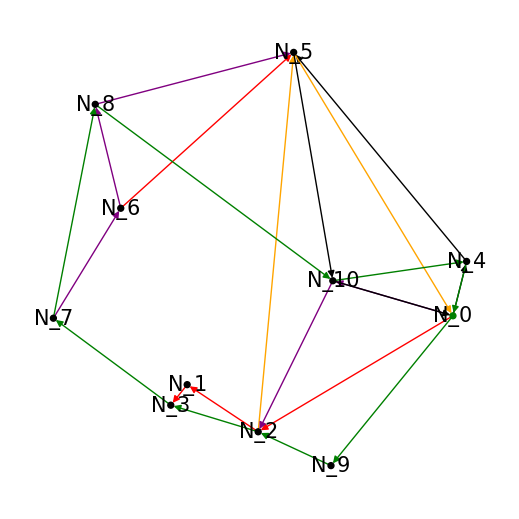

In [11]:
from ruteo_alns import ruteo_ALNS
def simular_ejecucion_P(grafo_inicial = G, T=1, F=1, cap = cap_tpte/2):
    # Inicializar variables     
    # ---------------------
    G0 = grafo_inicial.copy()
    matriz_dst = calcular_matriz_dist(G0)
    ubicaciones = list(G0.nodes()) # Lista de ubicaciones
    inventarios = [G0.nodes(data=True)[i]['Inv'] for i in ubicaciones] # Lista de inventarios
    h = [G0.nodes(data=True)[i]['h'] for i in ubicaciones] # Lista de costos de inventario
    rutas = {t : None for t in range(T)} # Lista de rutas
    dem_historico = simular_demanda_previa(G0, dist = 'n', T=1000) 
    perdido = 0
    print("Inventario inicial: ")
    for nodo in G0.nodes(data=True):
            print(nodo[0],nodo[1]['Inv'])
    print("\n")

    for t in range(T):
        pronostico = {int(nodo[2:]):
                pronostico_SEDA(dem_historico[nodo], T = 1, pron = True, alpha=0.2, beta=0.1, theta=0.5)[0]
                for nodo in dem_historico.keys()}
        # print(pronostico)
         
        ruta_P = ruteo_ALNS(G0, pronostico, cap = cap, F = F, ruta = True, MRT = 10) + ['N_0']
        rutas[t] = ruta_P
        print(f"Ruta {t}: ", ruta_P )
        # visitas_proactiva = proactiva_inventario(G0, tolerancia = 0.2, dist = 'n', mu = 0, sigma = 0.1, M = 1000)

        G0, stock = ejecutar_ruta(G0, ruta_P, matriz_dst)
        G0, demanda, insatisfecho = realizacion_demanda(G0)
        
        perdido += insatisfecho

        #Actualizo demandas
        for nodo in ubicaciones:
            if nodo != 'N_0':
                dem_historico[nodo].append(demanda[nodo])


    print('\n')
    print("Inventario final: ")
    for nodo in G0.nodes(data=True):
        print(nodo[0],nodo[1]['Inv'])
    print(f'Demanda perdida total: {perdido} | Demanda perdida promedio: {perdido/T}')        

    graficar_rutas(rutas, G0)

simular_ejecucion_P(grafo_inicial = G, T = 5)

## Procesamiento de Resultados

In [12]:
N = len(G.nodes())-1
def generar_df(rutas, N):

    rutas_bool = dict()
    for ruta, nodos in rutas.items():
        bools = dict()
        for i in range(1, N+1):
            if f'N_{i}' in nodos:
                bools[f'N_{i}'] = 1
            else:
                bools[f'N_{i}'] = 0
        rutas_bool[ruta] = bools
    
    df = pd.DataFrame.from_dict(rutas_bool, orient='index')
    
    df.rename(columns={'index': 'Ruta', 0: 'Nodo'}, inplace=True)
    df.rename_axis('Ruta', inplace=True)
    return df

df = generar_df(mis_rutas, N)
df['sum'] = df.sum(axis=1)


In [13]:
df_nodos = pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index')
df_nodos = df_nodos.iloc[1:]
df_nodos['frec'] = (df.describe()).T['mean']
dem_historico_media = {nodo: np.mean(dem_historico[nodo]) for nodo in dem_historico.keys()}
df_nodos['dem_mean'] = dem_historico_media.values()
df_nodos

,Inv,Up,Low,Prod,h,coord_x,coord_y,pos,frec,dem_mean
N_1,99,174,0,75,0.23,152,180,"(152, 180)",0.0,74.995617
N_2,26,54,0,28,0.32,230,141,"(230, 141)",1.0,27.984718
N_3,8,30,0,22,0.33,134,163,"(134, 163)",1.0,22.059649
N_4,33,110,0,77,0.23,459,282,"(459, 282)",1.0,77.013864
N_5,148,213,0,65,0.18,269,455,"(269, 455)",0.0,64.872473
N_6,101,138,0,37,0.29,79,326,"(79, 326)",0.0,37.172265
N_7,123,237,0,114,0.42,5,235,"(5, 235)",0.0,113.964641
N_8,40,129,0,89,0.42,51,412,"(51, 412)",1.0,89.304195
N_9,87,154,0,67,0.24,310,113,"(310, 113)",0.0,67.140313
N_10,102,189,0,87,0.43,312,266,"(312, 266)",0.0,87.028660


In [14]:
indices_mayores = df_nodos[df_nodos['frec'] > 0.75].index
indices_medios = df_nodos[(df_nodos['frec'] > 0.45) & (df_nodos['frec'] <= 0.75)].index
indices_menores = df_nodos[df_nodos['frec'] <= 0.45].index

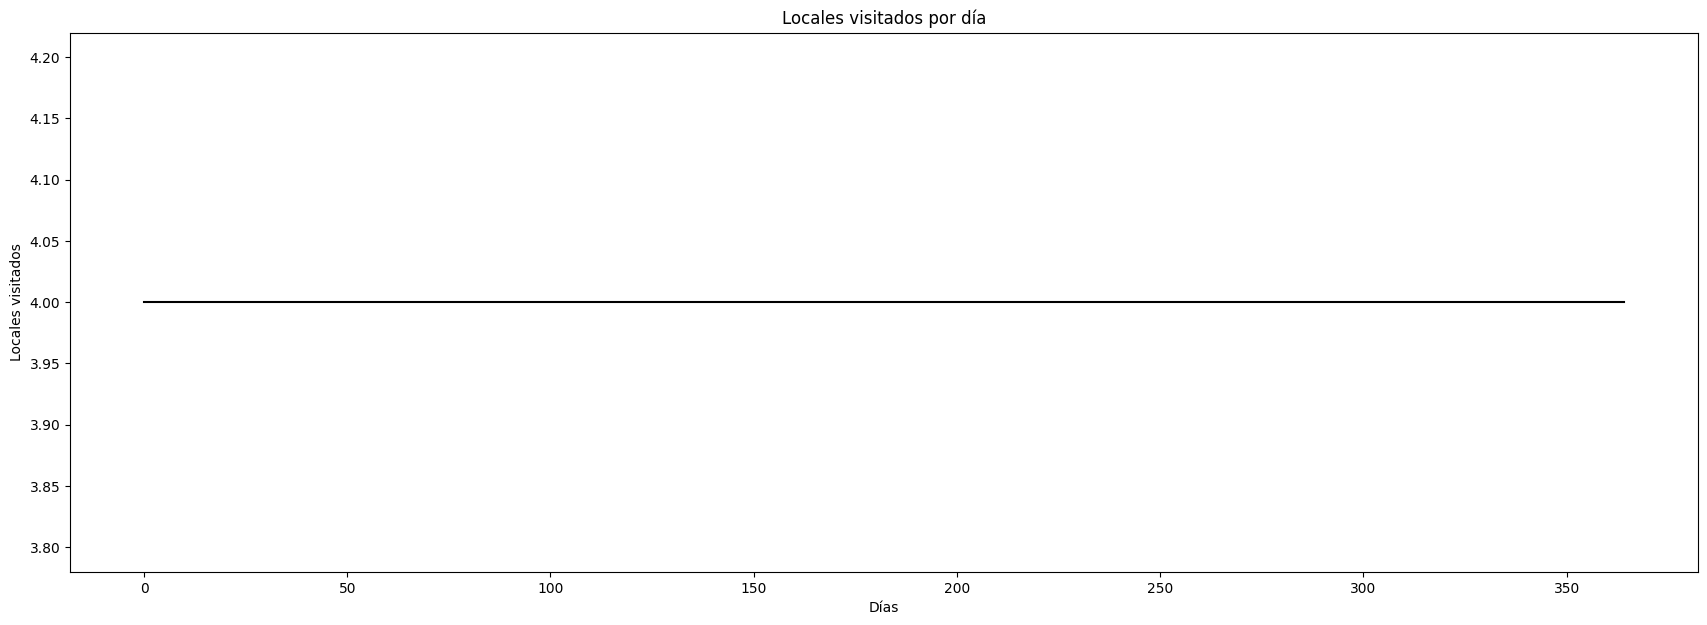

In [15]:
# graficaremos una serie de tiempo para el total de locales en cada día
# para esto, debemos sumar la cantidad de locales visitados en cada día, ya lo hicimos en la última columna

plt.figure(figsize=(21, 7))
plt.plot(df['sum'], '-', color='black')
plt.xlabel('Días')
plt.ylabel('Locales visitados')
plt.title('Locales visitados por día')
plt.show()

In [16]:
"""
# replicamos algo así pero ahora para cada local en vez de la suma, lo haremos sobre el mismo gráfico
# lo haremos solo con los primeros 150 días
plt.figure(figsize=(30, 7))
for i in range(1, N+1):
    plt.plot(df[f'N_{i}'][:150], '-', label=f'N_{i}')
plt.xlabel('Días')
plt.ylabel('Locales visitados')
plt.title('Locales visitados por día')
plt.legend()
plt.show()
"""

"\n# replicamos algo así pero ahora para cada local en vez de la suma, lo haremos sobre el mismo gráfico\n# lo haremos solo con los primeros 150 días\nplt.figure(figsize=(30, 7))\nfor i in range(1, N+1):\n    plt.plot(df[f'N_{i}'][:150], '-', label=f'N_{i}')\nplt.xlabel('Días')\nplt.ylabel('Locales visitados')\nplt.title('Locales visitados por día')\nplt.legend()\nplt.show()\n"

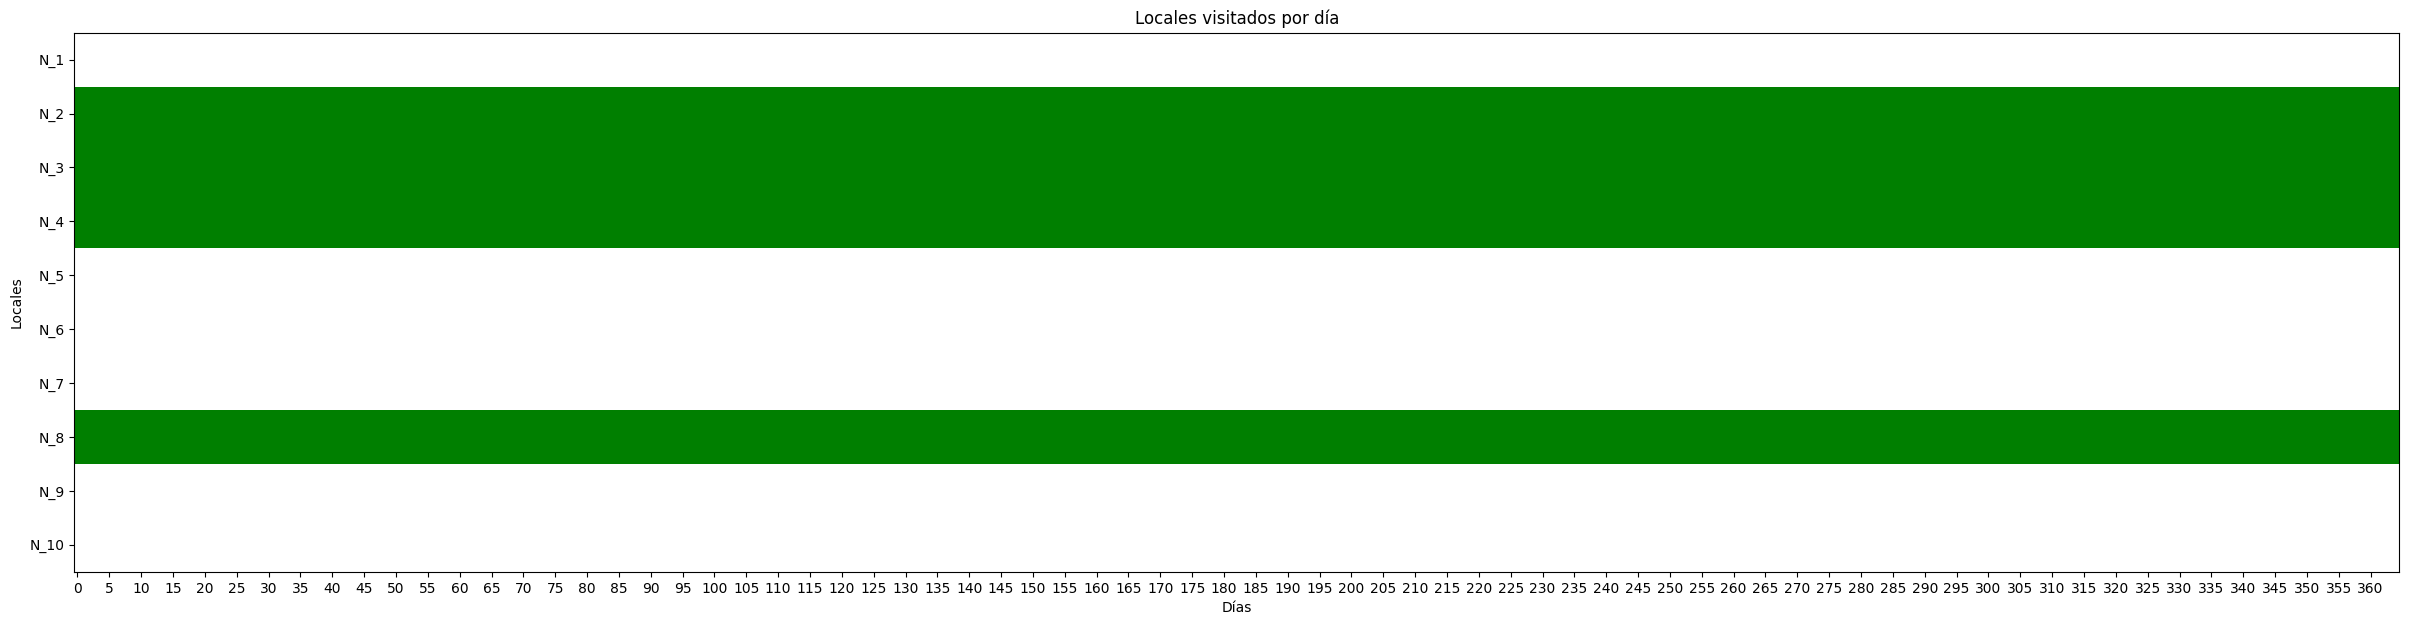

In [17]:

from matplotlib.colors import ListedColormap


# Define colormap

cmap = ListedColormap(['w', 'g'], N=2)

# Plot matrix

fig, ax = plt.subplots(figsize=(30, 7))
if 'sum' in df.columns:
    df.drop('sum', axis=1, inplace=True)
ax.imshow(df.T, cmap=cmap, vmin=0, vmax=1, aspect='auto')
ax.set_title('Locales visitados por día')
ax.set_xlabel('Días')
ax.set_ylabel('Locales')
ax.set_yticks(np.arange(N))
ax.set_yticklabels([f'N_{i}' for i in range(1, N+1)])
ax.set_xticks(np.arange(0, len(df), 5))

# modificamos el tamaño de la figura

plt.show()

In [18]:
cantidad_06 = len(df_nodos[df_nodos['frec'] >= 0.5])
cantidad_04 = len(df_nodos[df_nodos['frec'] < 0.5])

print (f'Locales visitados más de 50% de los días: {cantidad_06}, que corresponde a un {cantidad_06/N*100}%')
print (f'Locales visitados menos de 50% de los días: {cantidad_04}, que corresponde a un {cantidad_04/N*100}%')

Locales visitados más de 50% de los días: 4, que corresponde a un 40.0%
Locales visitados menos de 50% de los días: 6, que corresponde a un 60.0%


In [19]:
def dispersion_intervalos(df):
    '''
    Función que calcula la cantidad promedio de días entre visitas a cada local.
    También entrega la desviación estándar de los intervalos.
    '''
    df = df.copy()
    if 'sum' in df.columns:
        df.drop('sum', axis=1, inplace=True)
    datos = {nodo: {'mean': None, 'std': None} for nodo in df.columns}
    for nodo in df.columns:
        largos = []
        ultima_visita = 0
        for dia in range(len(df)):
            if df[nodo][dia] == 1:
                if dia - ultima_visita > 3:
                    #print(f'El local {nodo} no fue visitado por {dia - ultima_visita} días')
                    pass
                largos.append(dia - ultima_visita)
                ultima_visita = dia
        datos[nodo]['mean'] = np.mean(largos)
        datos[nodo]['std'] = np.std(largos)
    datos_df = pd.DataFrame.from_dict(datos, orient='index')
    return datos_df

datos = dispersion_intervalos(df)
        

df_nodos['mean'] = datos['mean']
df_nodos['std'] = datos['std']
df_nodos['porcentaje demanda'] = df_nodos['dem_mean'] / df_nodos['Up']
df_nodos['porcentaje dem. inicial'] = df_nodos['Prod'] / df_nodos['Up']
df_nodos_corr = df_nodos[['Inv','Up','Low','Prod','h','frec','mean','std','dem_mean','porcentaje demanda','porcentaje dem. inicial']]


C:\Users\pato2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pato2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\pato2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\pato2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value enco

In [20]:
df_nodos

,Inv,Up,Low,Prod,h,coord_x,coord_y,pos,frec,dem_mean,mean,std,porcentaje demanda,porcentaje dem. inicial
N_1,99,174,0,75,0.23,152,180,"(152, 180)",0.0,74.995617,NaN,NaN,0.431009,0.431034
N_2,26,54,0,28,0.32,230,141,"(230, 141)",1.0,27.984718,0.99726,0.052271,0.518236,0.518519
N_3,8,30,0,22,0.33,134,163,"(134, 163)",1.0,22.059649,0.99726,0.052271,0.735322,0.733333
N_4,33,110,0,77,0.23,459,282,"(459, 282)",1.0,77.013864,0.99726,0.052271,0.700126,0.700000
N_5,148,213,0,65,0.18,269,455,"(269, 455)",0.0,64.872473,NaN,NaN,0.304566,0.305164
N_6,101,138,0,37,0.29,79,326,"(79, 326)",0.0,37.172265,NaN,NaN,0.269364,0.268116
N_7,123,237,0,114,0.42,5,235,"(5, 235)",0.0,113.964641,NaN,NaN,0.480863,0.481013
N_8,40,129,0,89,0.42,51,412,"(51, 412)",1.0,89.304195,0.99726,0.052271,0.692281,0.689922
N_9,87,154,0,67,0.24,310,113,"(310, 113)",0.0,67.140313,NaN,NaN,0.435976,0.435065
N_10,102,189,0,87,0.43,312,266,"(312, 266)",0.0,87.028660,NaN,NaN,0.460469,0.460317


In [21]:
df_nodos_corr.corr()

,Inv,Up,Low,Prod,h,frec,mean,std,dem_mean,porcentaje demanda,porcentaje dem. inicial
Inv,1.000000,0.920067,NaN,0.473141,-0.171926,-0.921026,NaN,NaN,0.471594,-0.832881,-0.832074
Up,0.920067,1.000000,NaN,0.780458,0.029009,-0.811959,NaN,NaN,0.779356,-0.590817,-0.589608
Low,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Prod,0.473141,0.780458,NaN,1.000000,0.339610,-0.356062,NaN,NaN,0.999991,0.000568,0.001998
h,-0.171926,0.029009,NaN,0.339610,1.000000,0.151773,NaN,NaN,0.341198,0.327735,0.326537
frec,-0.921026,-0.811959,NaN,-0.356062,0.151773,1.000000,NaN,NaN,-0.355008,0.845425,0.845384
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dem_mean,0.471594,0.779356,NaN,0.999991,0.341198,-0.355008,NaN,NaN,1.000000,0.001734,0.003145
porcentaje demanda,-0.832881,-0.590817,NaN,0.000568,0.327735,0.845425,NaN,NaN,0.001734,1.000000,0.999985


In [22]:
def proactiva_inventario(G, pronostico):
    """
    Función que verifica que locales deben ser visitados en base a su inventario. 
    En caso de que el inventario se encuentre bajo el umbral de tolerancia, se retorna True.
    """
    visitas = {nodo : False for nodo in G.nodes()}
    for nodo in G.nodes(data=True):
        id_nodo = int(nodo[0][2:])-1
        media = mu[id_nodo]
        desviacion = sd[id_nodo]
        s = media + norm.ppf((1 - alfa)/2)* desviacion  #Stock de seguridad
        if nodo[1]['Inv'] <= s:
            visitas[nodo[0]] = True
            
    for nodo in G.nodes(data=True):
        mean = nodo[1]['Prod'] + mu
        sd = nodo[1]['Prod'] * sigma
        l_inf, l_sup = IC_nrm(mean, sd, alfa = 0.95)
        pronostico = l_sup
        if nodo[1]['Inv'] - pronostico <= tolerancia * nodo[1]['Up']:
            visitas[nodo[0]] = True
    
    return visitas